In [2]:
import os
import sys
import numpy as np
from PIL import Image

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_tracking_loader \
    import ArgoverseTrackingLoader
from argoverse.utils.camera_stats import RING_CAMERA_LIST

from src.utils.configs import get_default_configuration
from src.data.utils import get_visible_mask, get_occlusion_mask, encode_binary_labels
from src.data.argoverse.utils import get_object_masks, get_map_mask


In [85]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
config = get_default_configuration()
config.merge_from_file('configs/datasets/argoverse.yml')

# Create an Argoverse map instance
map_data = ArgoverseMap()

split = 'train'
path = os.path.join(os.path.expandvars(config.dataroot), split)
print("Loading Argoverse tracking data at " + path)
loader = ArgoverseTrackingLoader(path)


In [82]:
dic = {}
for scene in loader:
    print("\n\n==> Processing scene: " + scene.current_log)
    # Iterate over each camera and each frame in the sequence
    for frame in range(scene.num_lidar_frame):
        for camera in RING_CAMERA_LIST:
            # Compute object masks
            masks = get_object_masks(scene, camera, frame, config.map_extents,
                                     config.map_resolution)
            
            # Compute drivable area mask
            masks[0] = get_map_mask(scene, camera, frame, map_data, config.map_extents,
                                    config.map_resolution)
            
            # Ignore regions of the BEV which are outside the image
            calib = scene.get_calibration(camera)
            masks[-1] |= ~get_visible_mask(calib.K, calib.camera_config.img_width,
                                           config.map_extents, config.map_resolution)

            # Ignore regions of the BEV which are occluded (based on LiDAR data)
            lidar = scene.get_lidar(frame)
            cam_lidar = calib.project_ego_to_cam(lidar)
            masks[-1] |= get_occlusion_mask(cam_lidar, config.map_extents, 
                                            config.map_resolution)
            dic[camera] = masks
            print(camera, frame, 'done')
        break
    break



==> Processing scene: dcdcd8b3-0ba1-3218-b2ea-7bb965aad3f0
ring_front_center 0 done
ring_front_left 0 done
ring_front_right 0 done
ring_rear_left 0 done
ring_rear_right 0 done
ring_side_left 0 done
ring_side_right 0 done


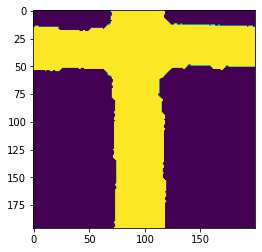

In [88]:
plt.imshow(dic['ring_front_center'][0, :, :])

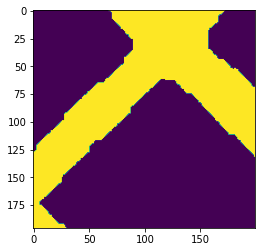

In [35]:
plt.imshow(dic['ring_front_left'][0, :, :])

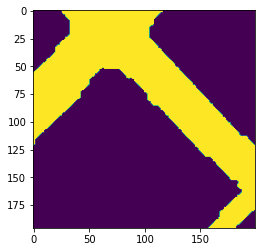

In [28]:
plt.imshow(dic['ring_front_right'][0, :, :])

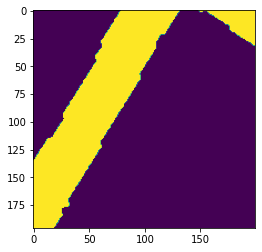

In [29]:
plt.imshow(dic['ring_rear_left'][0, :, :])

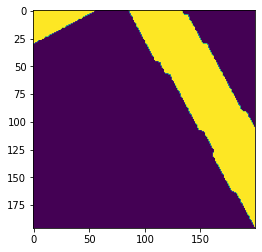

In [30]:
plt.imshow(dic['ring_rear_right'][0, :, :])

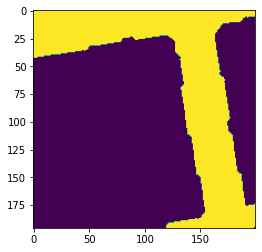

In [31]:
plt.imshow(dic['ring_side_left'][0, :, :])

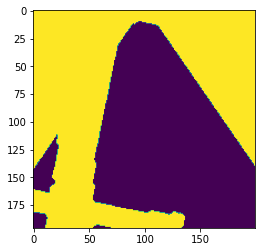

In [97]:
plt.imshow(dic['ring_side_right'][0, :, :] | ~get_visible_mask(calib.K, calib.camera_config.img_width,config.map_extents, config.map_resolution))

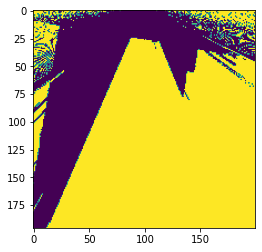

In [99]:
plt.imshow(get_occlusion_mask(cam_lidar, config.map_extents, config.map_resolution))

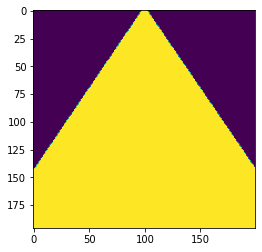

In [16]:
plt.imshow(get_visible_mask(calib.K, calib.camera_config.img_width,config.map_extents, config.map_resolution))


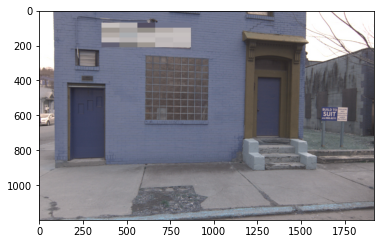

In [87]:
timestamp = scene.image_timestamp_list_sync[camera][frame]
path = os.path.join('data', 'argo', 'argoverse-tracking', 'train', scene.current_log, camera, camera + '_' + str(timestamp) + '.jpg')
image = cv2.imread(path)
plt.imshow(image)

In [59]:
timestamp = scene.image_timestamp_list_sync['ring_front_center'][0]
image = scene.get_image_at_timestamp(timestamp, 'ring_front_center', scene)
# image = Image.fromarray(image).resize(self.image_size)

ERROR:root:Cannot find ring_front_center image at timestamp 315977112113363064 in log 
--------------------------------------------------------------------
------Log id: dcdcd8b3-0ba1-3218-b2ea-7bb965aad3f0
--------------------------------------------------------------------
Time: 15.400110000000002 sec
# frame lidar (@10hz): 155
# frame ring camera (@30hz): 466
# frame stereo camera (@5hz): 78

Total images: 3418
Total bounding box: 4850
        


In [47]:
image

In [42]:
timestamp = str(scene.image_timestamp_list_sync[camera][frame])
# output_path = os.path.join(config.label_root, split, 
#                            scene.current_log, camera, 
#                            f'{camera}_{timestamp}.png')

'315977112113363064'

In [36]:
masks[-1].shape

(196, 200)

In [37]:
scene.current_log

'dcdcd8b3-0ba1-3218-b2ea-7bb965aad3f0'

In [39]:
for camera, timestamps in scene.image_timestamp_list_sync.items():
    break


In [41]:
camera

'ring_front_center'

In [ ]:
        # Iterate over sequences
        for log in loader:

            # Check if the log is within the current dataset split
            logid = log.current_log
            if log_names is not None and logid not in log_names:
                continue

            print("log id is {}".format(logid))
            self.calibs[logid] = dict()
            for camera, timestamps in log.image_timestamp_list_sync.items():

                if camera not in RING_CAMERA_LIST:
                    continue

                # Load image paths
                for timestamp in timestamps:
                    self.examples[timestamp] = (split, logid, camera)

        self.timestamps = sorted(self.examples.keys())

In [ ]:
from src.data.data_factory import build_dataloaders
train_loader, val_loader = build_dataloaders(config.train_dataset, config)
# Create datasets using new argoverse splits
train_data = ArgoverseMapDataset(train_loaders, config.label_root, 
                                 config.img_size, TRAIN_LOGS)
